# Emotion Detection via Pitch Information

## Dataset Generation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import librosa
import itertools

import scipy.fftpack as sf
from scipy.io import wavfile

In [2]:
os.chdir("/Users/hyunwoogu/Dropbox/2018MARG/Emotion Recognition/Dataset/RAVDESS")

In [3]:
def Frequency(X, F_sample, Low_cutoff=80, High_cutoff= 300):
        M = X.size 
        if M==0:
            return np.array([0])
        
        Spectrum = sf.rfft(X, n=M) 
        [Low_cutoff, High_cutoff, F_sample] = map(float, [Low_cutoff, High_cutoff, F_sample])

        [Low_point, High_point] = map(lambda F: F/F_sample * M, [Low_cutoff, High_cutoff])
        [Low_point, High_point] = map(int, [Low_cutoff, High_cutoff])
        
        if Spectrum[Low_point : High_point].size == 0:
            return(0)

        maximumFrequency = np.where(Spectrum == np.max(Spectrum[Low_point : High_point]))
        
        return maximumFrequency

In [12]:
Happy = "03-01-03-{0[0]:02d}-{0[1]:02d}-{0[2]:02d}-{0[3]:02d}.wav"
Sad   = "03-01-04-{0[0]:02d}-{0[1]:02d}-{0[2]:02d}-{0[3]:02d}.wav"

Happy_train = np.zeros(10)

k = [(1, 1, 1), (1, 1, 2), (1, 2, 1), (1, 2, 2), (2, 1, 1), (2, 1, 2), (2, 2, 1), (2, 2, 2)]

In [20]:
Sad_train   = np.zeros(10)

In [13]:
for i in k:
    for j in range(1, 25):
        index = (i, j)
        index = index[0] + (index[1],)
        
        files    = Happy.format(index)
        data, fs = librosa.load(files)

        n    = data.size

        EffectiveInx= np.argwhere(data > 0.001)
        Effective   = data[EffectiveInx]
        n           = Effective.size

        step          = math.floor(n / 100)
        mx_res= mn_res= np.array([])

        for l in range(10):
            now = range(step*l, step*(l+1))
            mx  = Frequency(np.reshape(Effective[now], step), fs)
            mx_res = np.append(mx_res, mx)

        mx_res_mean = np.mean(mx_res)
        mx_res_std  = np.std(mx_res)
        mx_res      = (mx_res-mx_res_mean)/(mx_res_std+1e-3)
        
        Happy_train = np.vstack((Happy_train, mx_res))

Happy_train = np.delete(Happy_train, 0, 0)

In [6]:
data, fs = librosa.load('03-01-03-01-01-02-06.wav')
n    = data.size

EffectiveInx= np.argwhere(data > 0.001)
Effective   = data[EffectiveInx]
n           = Effective.size

step          = math.floor(n / 100)
mx_res= mn_res= np.array([])

for l in range(10):
    now = range(step*l, step*(l+1))
    mx  = Frequency(np.reshape(Effective[now], step), fs)
    mx_res = np.append(mx_res, mx)

mx_res_mean = np.mean(mx_res)
mx_res_std  = np.std(mx_res)
mx_res      = (mx_res-mx_res_mean)/(mx_res_std+1e-3)

In [20]:
data, fs = librosa.load('03-01-03-01-01-02-06.wav')
n    = data.size

EffectiveInx= np.argwhere((data > 0.010) | (data < -0.001))
Effective   = data[EffectiveInx]

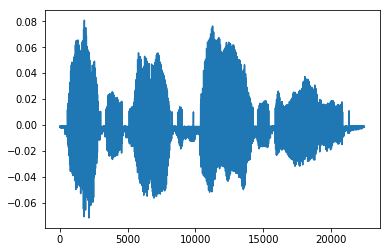

In [21]:
plt.plot(range(len(Effective)), Effective)

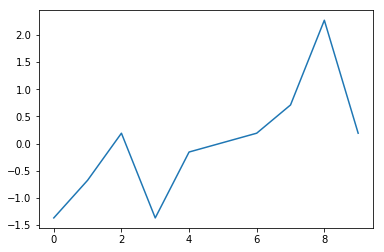

In [18]:
plt.plot(range(10), Happy_train[4])

In [21]:
for i in k:
    for j in range(1, 25):
        index = (i, j)
        index = index[0] + (index[1],)
        
        files    = Sad.format(index)
        data, fs = librosa.load(files)

        n    = data.size

        EffectiveInx= np.argwhere(data > 0.001)
        Effective   = data[EffectiveInx]
        n           = Effective.size

        step          = math.floor(n / 100)
        mx_res= mn_res= np.array([])

        for l in range(10):
            now = range(step*l, step*(l+1))
            mx  = Frequency(np.reshape(Effective[now], step), fs)
            mx_res = np.append(mx_res, mx)

        mx_res_mean = np.mean(mx_res)
        mx_res_std  = np.std(mx_res)
        mx_res      = (mx_res-mx_res_mean)/(mx_res_std+1e-3)
        
        Sad_train = np.vstack((Sad_train, mx_res))

Sad_train = np.delete(Sad_train, 0, 0)

In [22]:
HT = np.ones((192, 11))
ST = np.zeros((192, 11))

HT[:, :-1] = Happy_train
ST[:, :-1] = Sad_train

In [23]:
train = np.vstack((HT, ST))
np.random.shuffle(train)

TrainSet = train[range(300),:]
TestSet  = train[range(300,384),:]

## Model

In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.
/Users/hyunwoogu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [24]:
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [25]:
xTrain = TrainSet[:,0:10]
yTrain = TrainSet[:,10]

xTest  = TestSet[:,0:10]
yTest  = TestSet[:,10]

In [26]:
xTrain = np.reshape(xTrain, (300, 10, 1))
yTrain = np_utils.to_categorical(yTrain)
oneHotVecSize = yTrain.shape[1]

In [34]:
model = Sequential()
model.add(LSTM(128, input_shape = (10, 1)))
model.add(Dense(oneHotVecSize, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history = LossHistory()
history.init()

## Train!

Epoch 1/200
 - 2s - loss: 0.6949 - acc: 0.4667
Epoch 2/200
 - 0s - loss: 0.6932 - acc: 0.4967
Epoch 3/200
 - 0s - loss: 0.6935 - acc: 0.5000
Epoch 4/200
 - 0s - loss: 0.6920 - acc: 0.4967
Epoch 5/200
 - 0s - loss: 0.6910 - acc: 0.5100
Epoch 6/200
 - 0s - loss: 0.6910 - acc: 0.5200
Epoch 7/200
 - 0s - loss: 0.6893 - acc: 0.5367
Epoch 8/200
 - 0s - loss: 0.6915 - acc: 0.5367
Epoch 9/200
 - 0s - loss: 0.6867 - acc: 0.5633
Epoch 10/200
 - 0s - loss: 0.6862 - acc: 0.5900
Epoch 11/200
 - 0s - loss: 0.6909 - acc: 0.5567
Epoch 12/200
 - 0s - loss: 0.6837 - acc: 0.5933
Epoch 13/200
 - 0s - loss: 0.6842 - acc: 0.5767
Epoch 14/200
 - 0s - loss: 0.6853 - acc: 0.5700
Epoch 15/200
 - 0s - loss: 0.6825 - acc: 0.5867
Epoch 16/200
 - 0s - loss: 0.6899 - acc: 0.5733
Epoch 17/200
 - 0s - loss: 0.6791 - acc: 0.5900
Epoch 18/200
 - 0s - loss: 0.6787 - acc: 0.5933
Epoch 19/200
 - 0s - loss: 0.6784 - acc: 0.6067
Epoch 20/200
 - 0s - loss: 0.6787 - acc: 0.5933
Epoch 21/200
 - 0s - loss: 0.6777 - acc: 0.5867
E

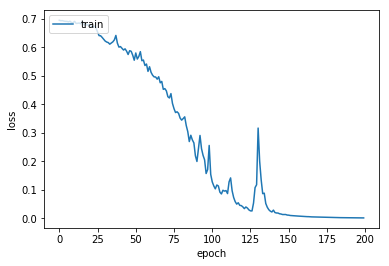

300/300 [==============================] - 0s 319us/step
acc: 100.00%


In [36]:
model.fit(xTrain, yTrain, epochs=200, batch_size=14, verbose=2, callbacks=[history])
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

scores = model.evaluate(xTrain, yTrain)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [37]:
seq_out  = []
pred_out = model.predict(np.reshape(xTest, [84,10,1]))

for i in range(84):
    idx = np.argmax(pred_out[i])
    seq_out.append([idx]) 
    
predicted = np.reshape(seq_out, [84])
np.mean(predicted == yTest)

0.44047619047619047

In [44]:
model.save_weights("weight.hdf5")

## Prediction

In [38]:
os.chdir("/Users/hyunwoogu/Dropbox/2018MARG/Emotion Recognition/Emotional Speech Recognition/pitch_detection")

In [39]:
def PredictEmotion(files):
    data, fs = librosa.load(files)
    n    = data.size
    
    EffectiveInx= np.argwhere(data > 0.001)
    Effective   = data[EffectiveInx]
    n           = Effective.size

    step          = math.floor(n / 100)
    mx_res= mn_res= np.array([])

    for l in range(10):
        now = range(step*l, step*(l+1))
        mx  = Frequency(np.reshape(Effective[now], step), fs)
        mx_res = np.append(mx_res, mx)

    mx_res_mean = np.mean(mx_res)
    mx_res_std  = np.std(mx_res)
    mx_res      = (mx_res-mx_res_mean)/(mx_res_std+1e-3)
    
    res = np.argmax(model.predict(np.reshape(mx_res, [1, 10, 1])))
    if res == 0:
        return("You are Sad:(")
    elif res == 1:
        return("You are Happy:)")

In [40]:
def PredictPlot(files):
    data, fs = librosa.load(files)
    n    = data.size
    
    EffectiveInx= np.argwhere(data > 0.001)
    Effective   = data[EffectiveInx]
    n           = Effective.size

    step          = math.floor(n / 100)
    mx_res= mn_res= np.array([])

    for l in range(10):
        now = range(step*l, step*(l+1))
        mx  = Frequency(np.reshape(Effective[now], step), fs)
        mx_res = np.append(mx_res, mx)

    mx_res_mean = np.mean(mx_res)
    mx_res_std  = np.std(mx_res)
    mx_res      = (mx_res-mx_res_mean)/(mx_res_std+1e-3)
    
    return(mx_res)

You are Sad:(


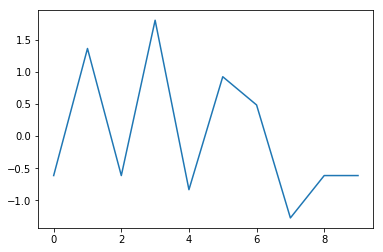

In [42]:
print(PredictEmotion("HW_Sad.wav"))
print(plt.plot(range(10), PredictPlot("HW_Sad.wav")))